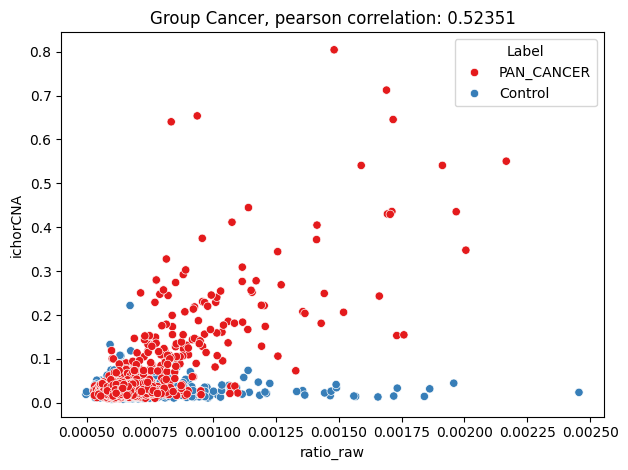

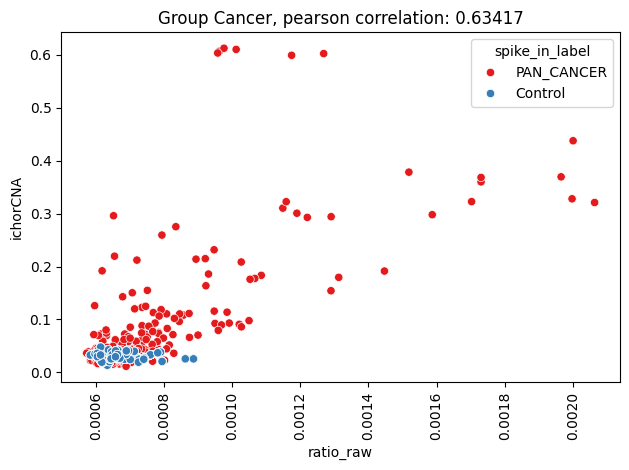

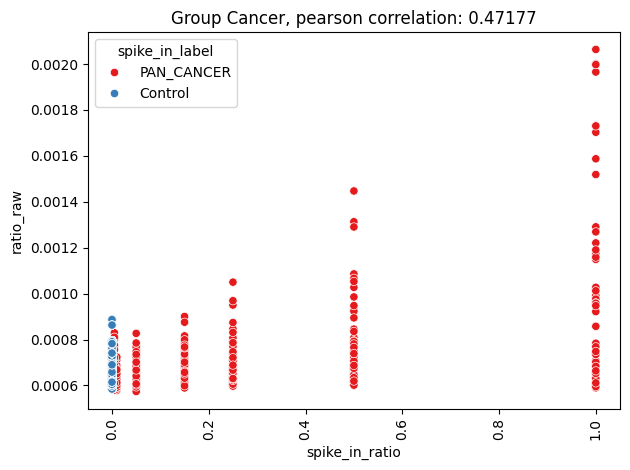

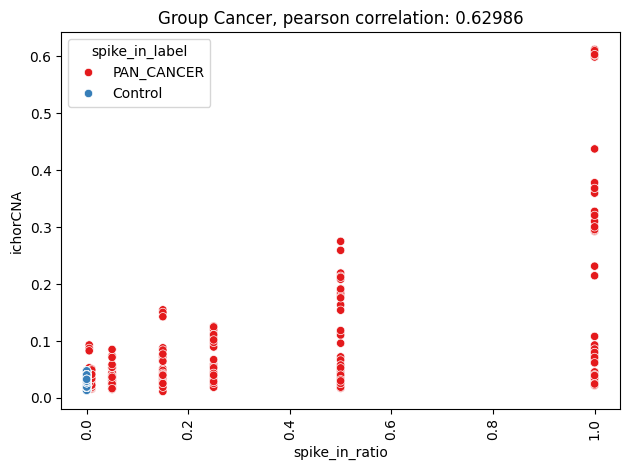

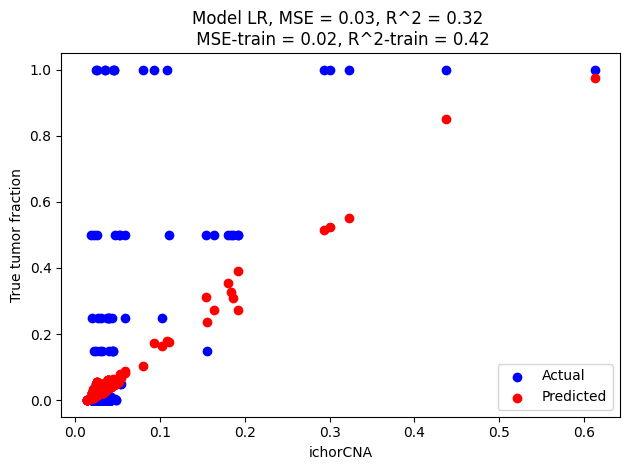

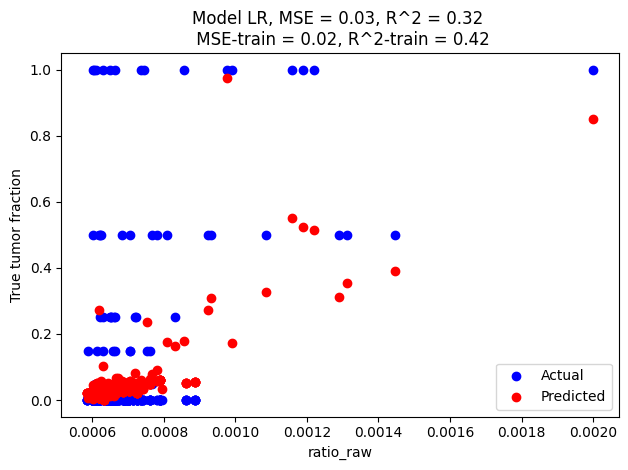

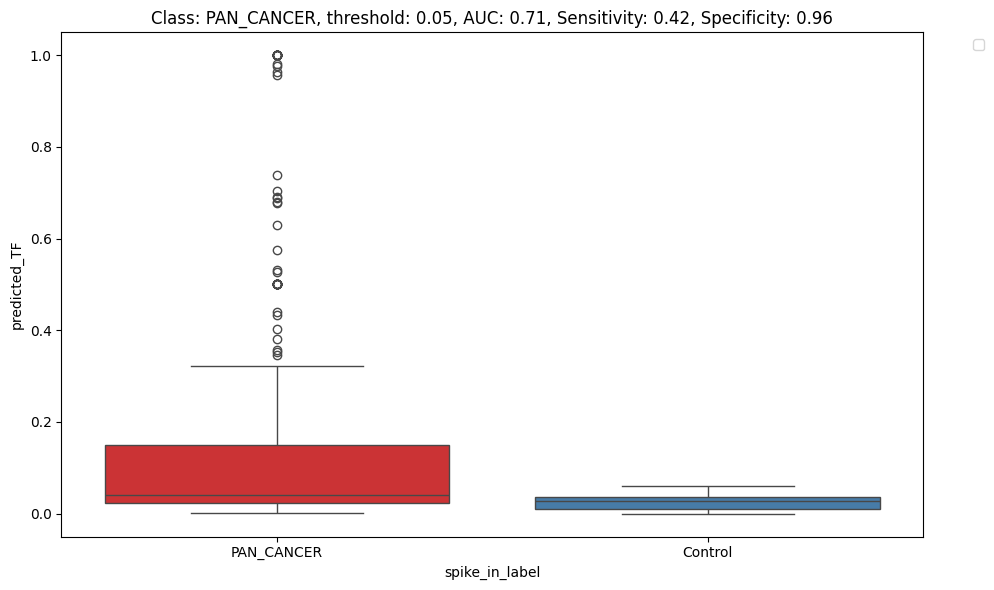

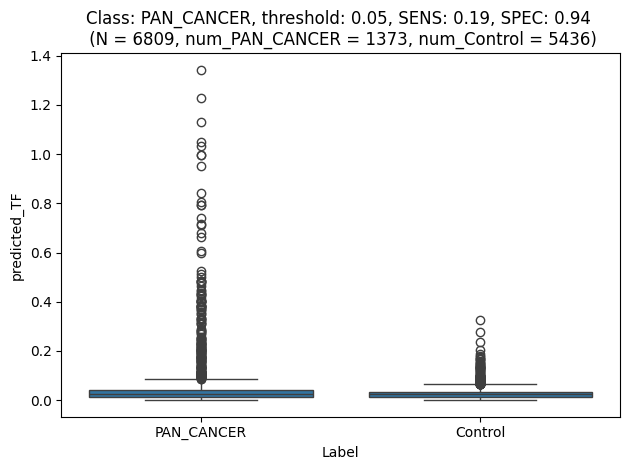

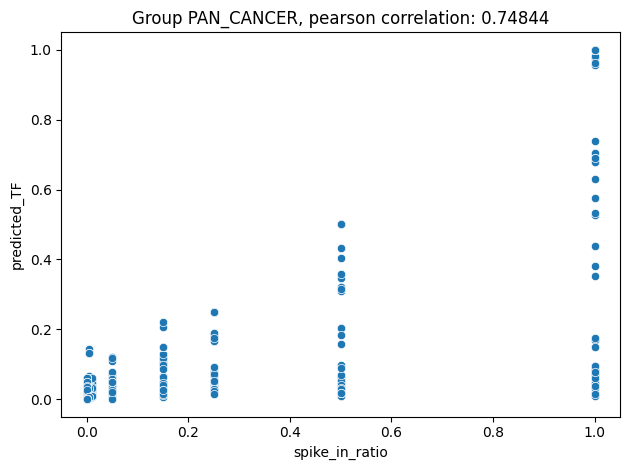

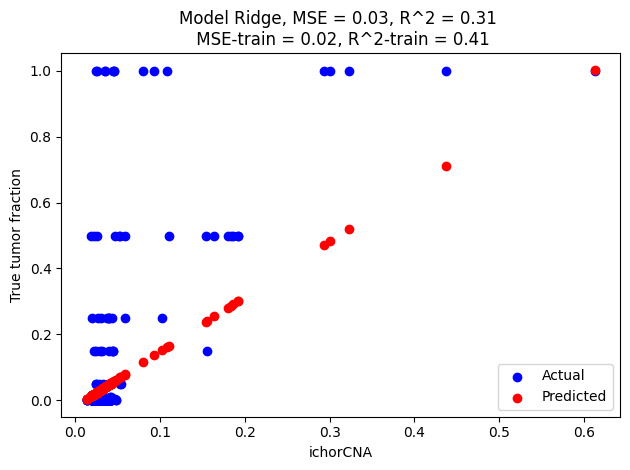

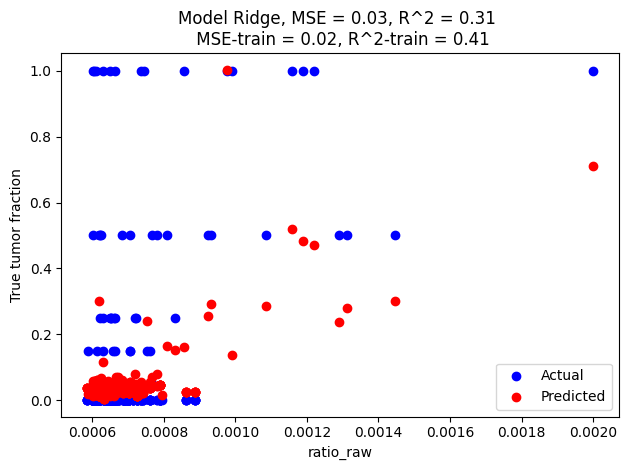

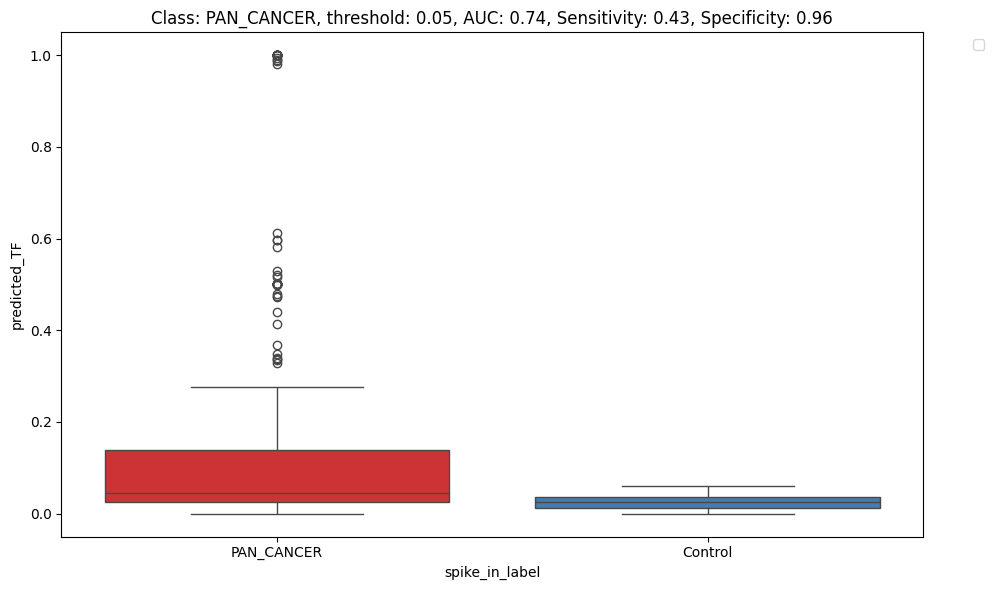

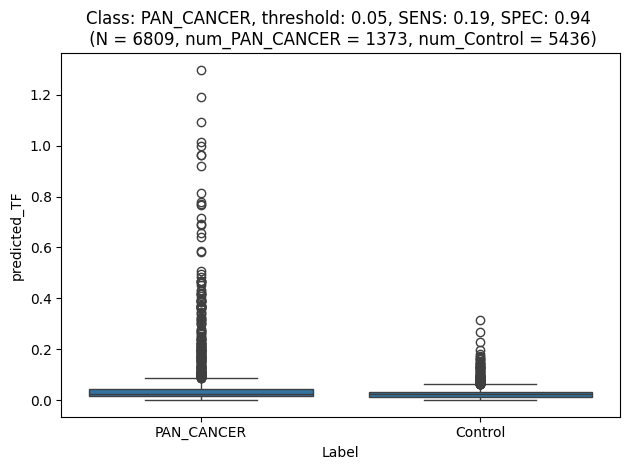

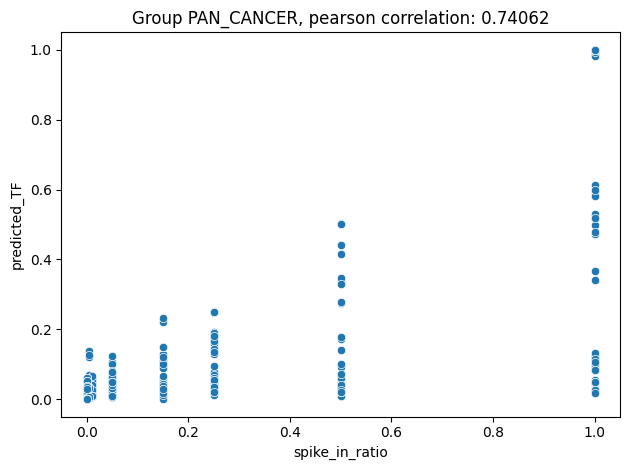

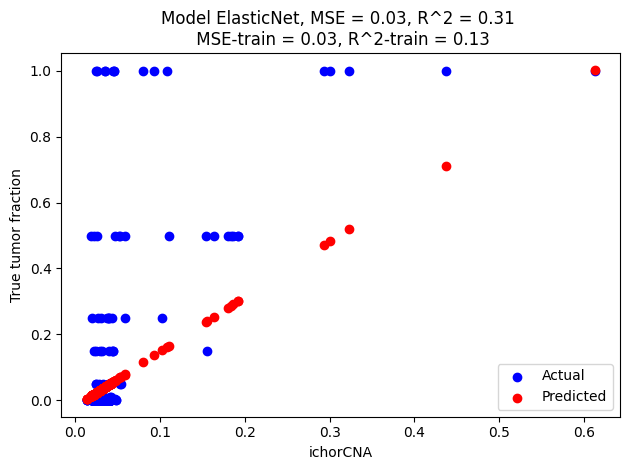

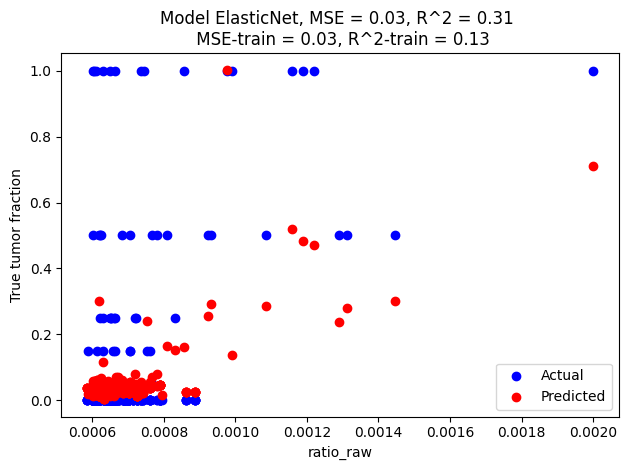

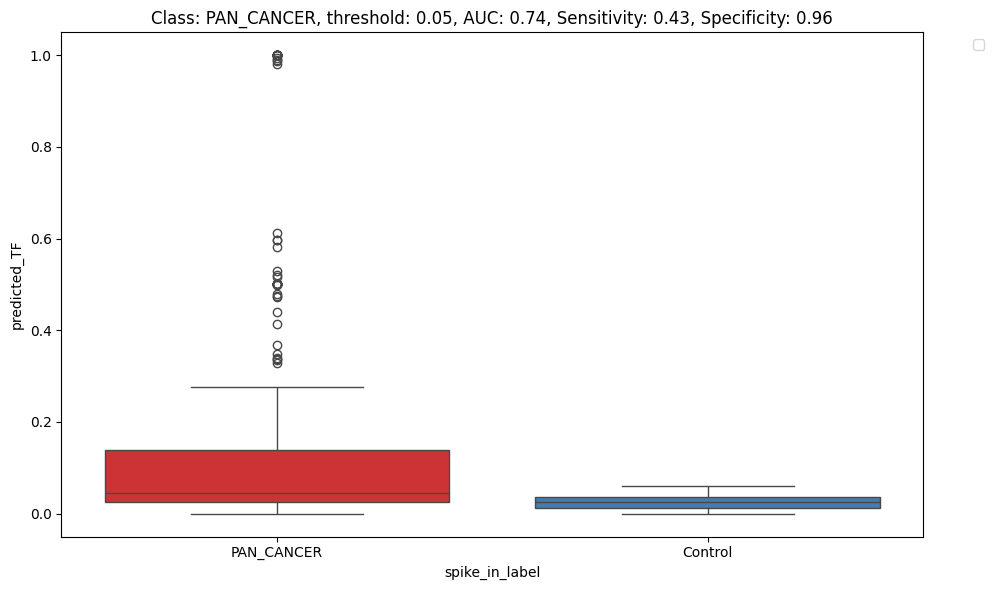

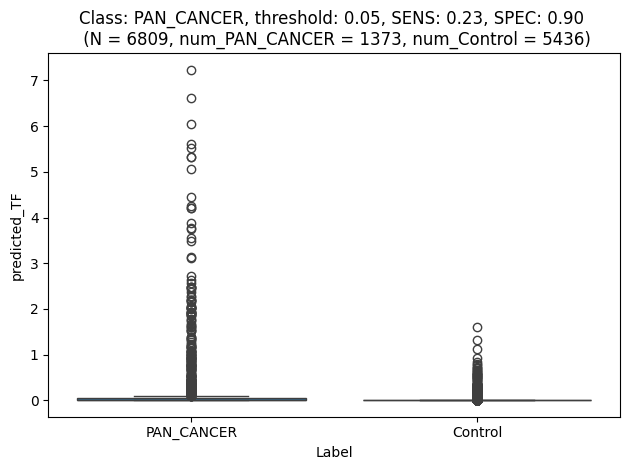

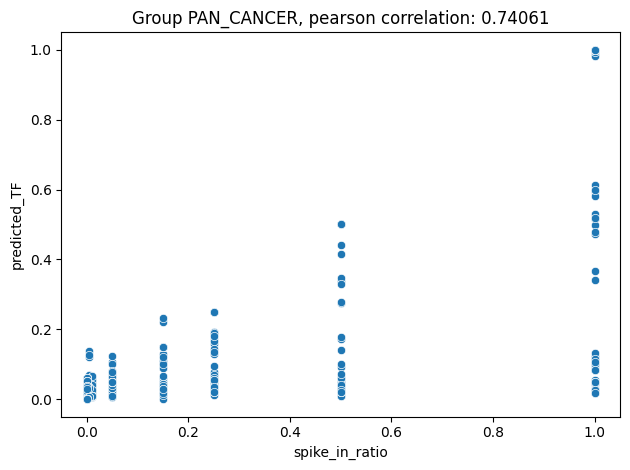

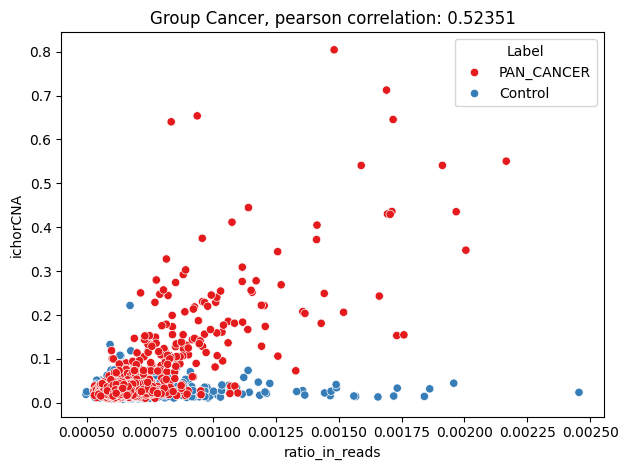

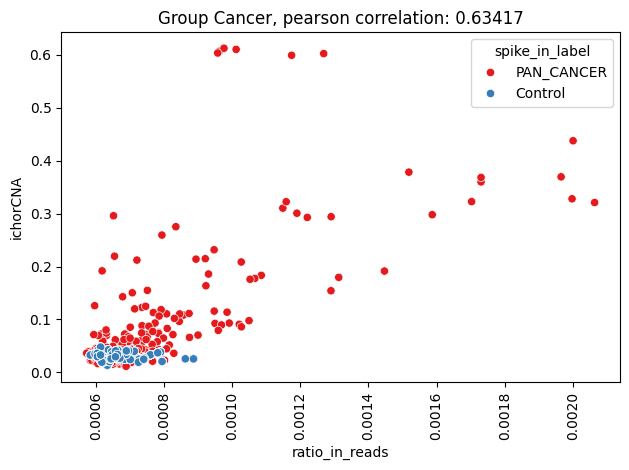

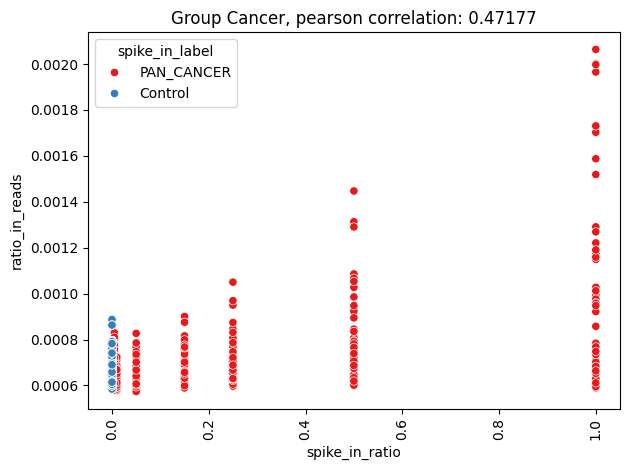

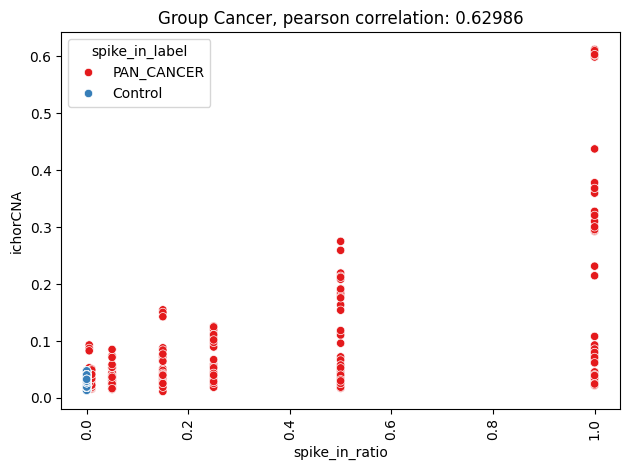

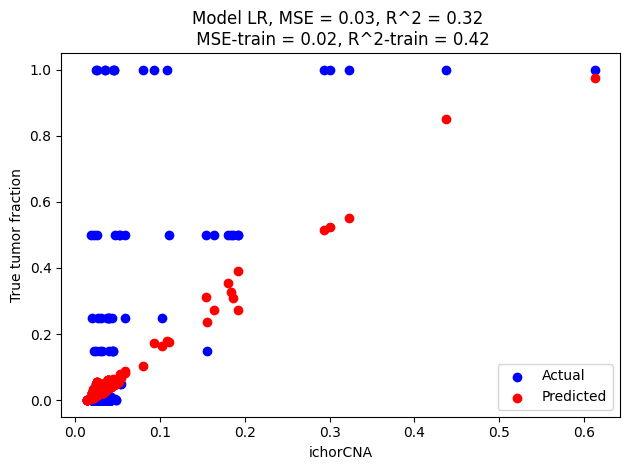

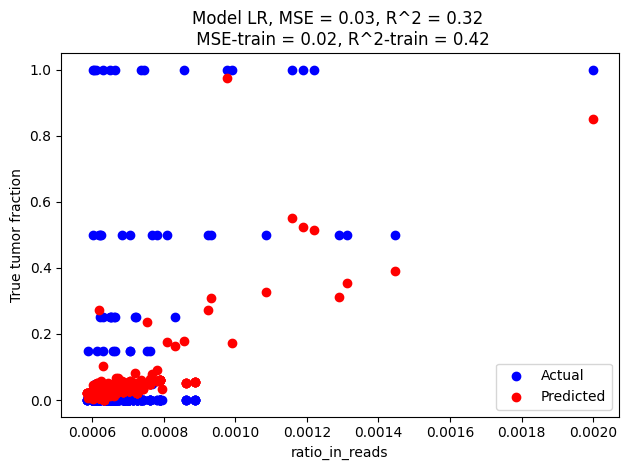

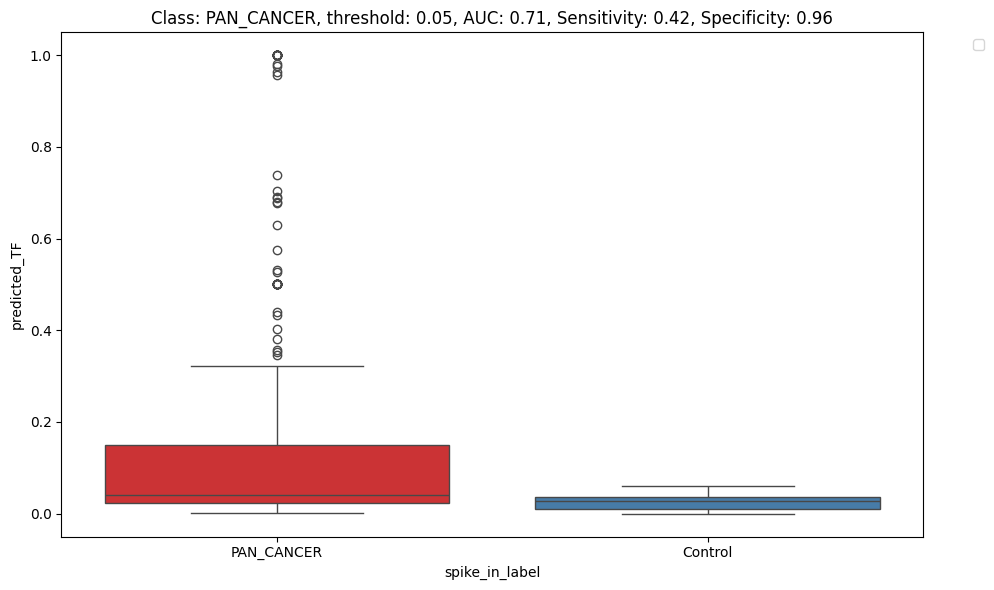

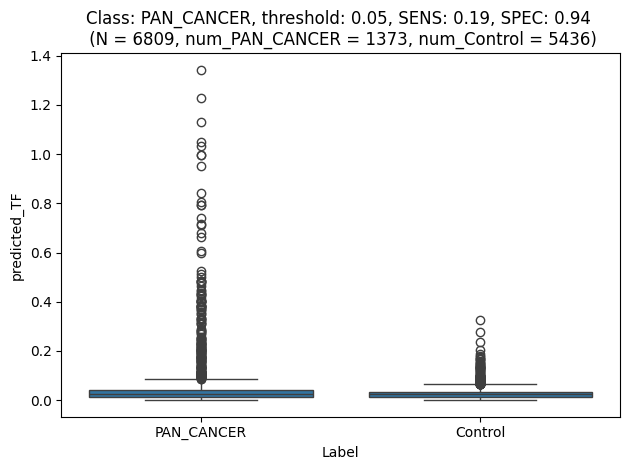

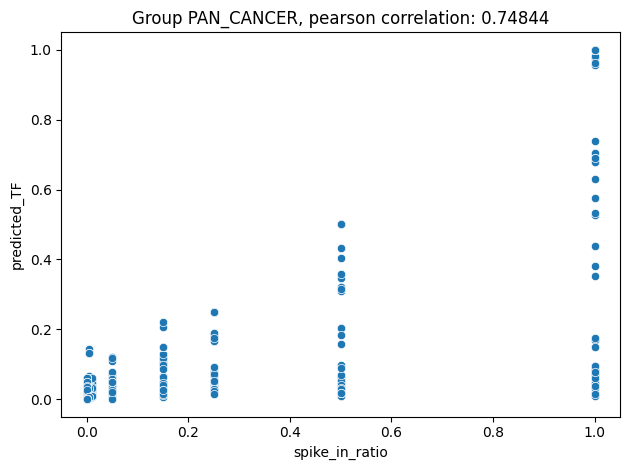

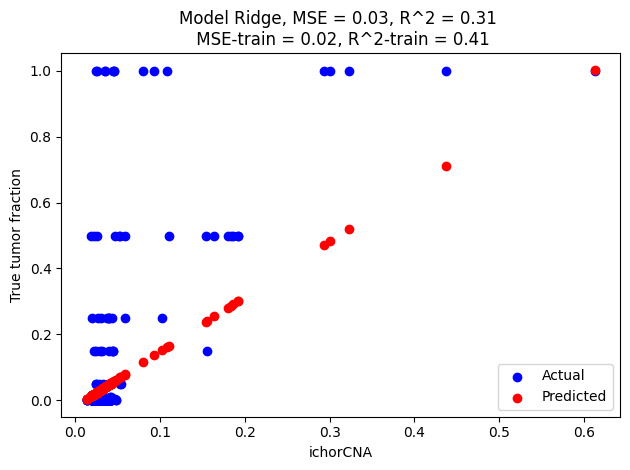

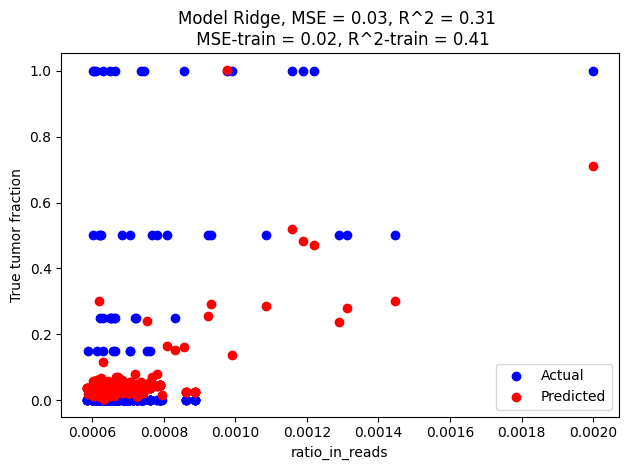

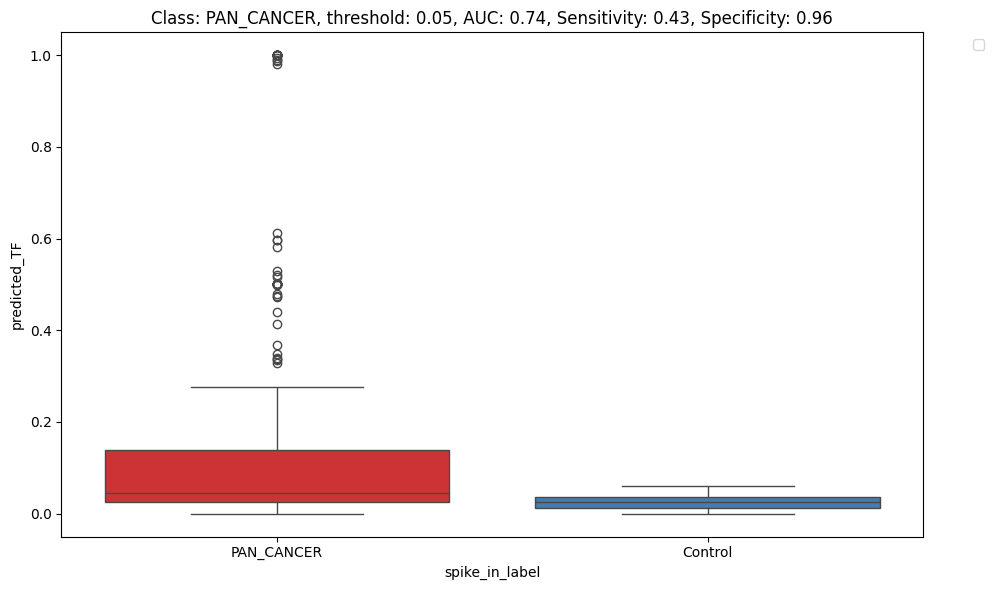

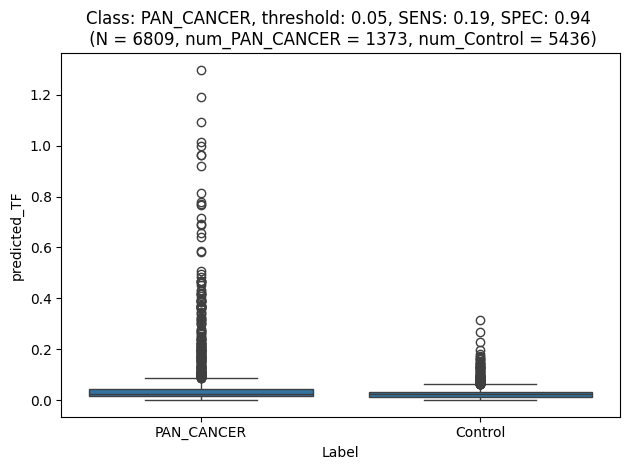

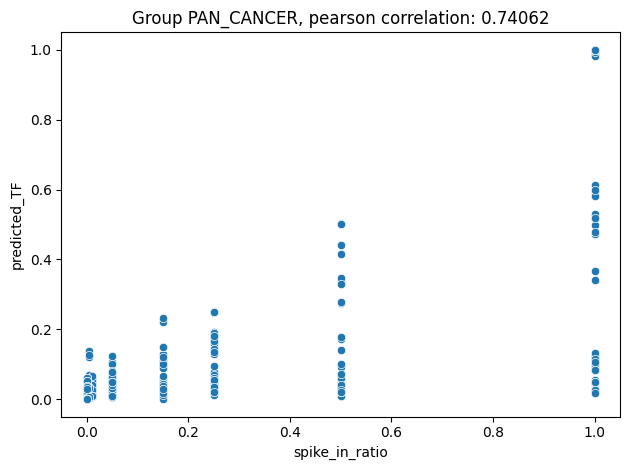

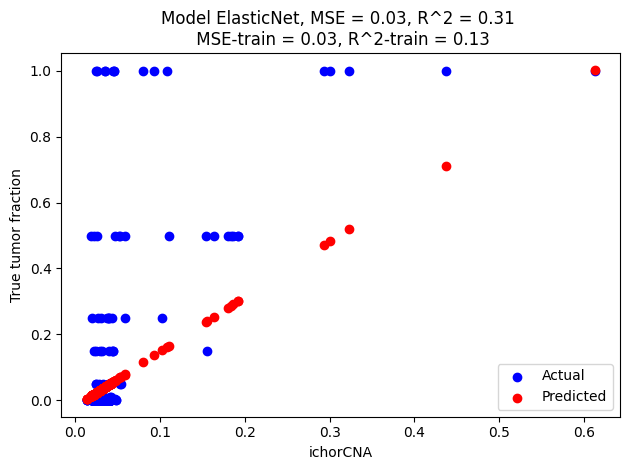

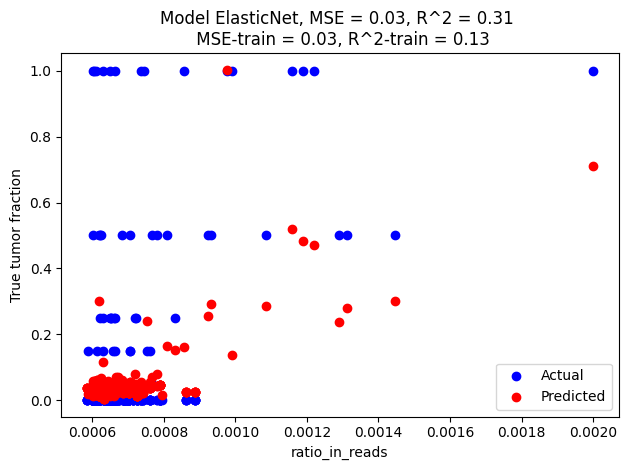

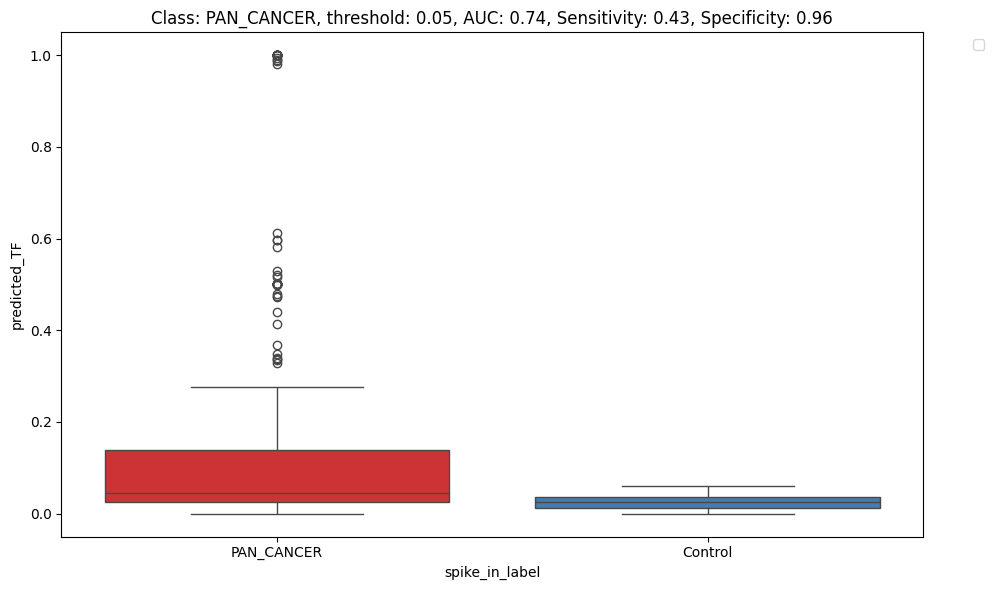

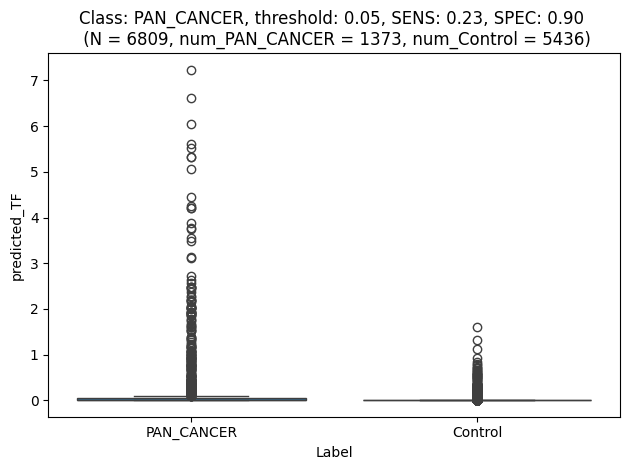

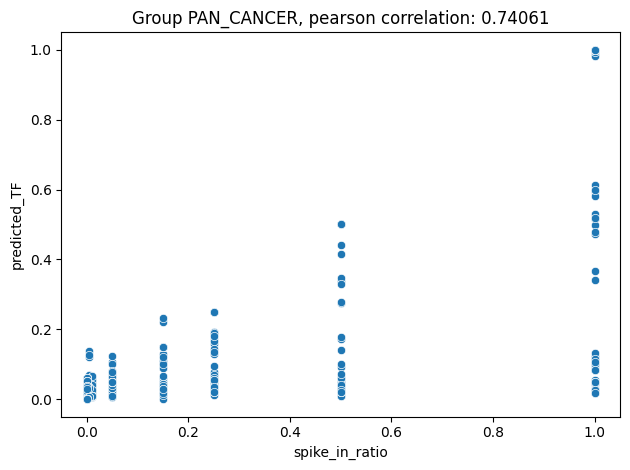

In [13]:
import pandas as pd
import numpy as np
import pathlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import roc_curve, auc
import scipy
warnings.filterwarnings('ignore')
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

data_version = "TMD_cov"
output_version = "20240910"

outdir = "/media/hieunguyen/GSHD_HN01/outdir"
PROJECT = "TMD450_TCGA_data_analysis"
thres_hypo = 0.3
thres_hyper = 0.6
mode = "all"

summarydf = pd.DataFrame()
input_cancer_class = "PAN_CANCER"

# selected_candi_features = "ratio_raw"
for selected_candi_features in ["ratio_raw", "ratio_in_reads"]:
    path_to_tf_output = os.path.join(outdir, PROJECT, output_version, "TF_output")
    path_to_02_tf_output = os.path.join(path_to_tf_output, "02_output")


    path_to_main_output = os.path.join(outdir, PROJECT, output_version)
    path_to_02_output = os.path.join(path_to_main_output, "PANCANCER02_output")
    path_to_03_output = os.path.join(path_to_main_output, "PANCANCER03_output")
    path_to_04_output = os.path.join(path_to_main_output, "PANCANCER04_output")
    path_to_06_output = os.path.join(path_to_main_output, "PANCANCER06_output")

    path_to_savefile = os.path.join(path_to_02_tf_output, "output", input_cancer_class, selected_candi_features)
    path_to_save_models = os.path.join(path_to_02_tf_output, "output", input_cancer_class, selected_candi_features, "models")
    os.system(f"mkdir -p {path_to_savefile}")
    os.system(f"mkdir -p {path_to_save_models}")

    metadata = pd.read_excel("metadata_cfDNA_lowpdepth_TMD_bam_cov.xlsx")
    metadata = metadata[metadata["Label"].isin([input_cancer_class, "Control"])]

    candidf = pd.read_excel(os.path.join(path_to_02_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))
    ichorcnadf = pd.read_excel("./ichorCNA/metadata_cfDNA_lowpdepth.xlsx")

    # keep only samples that have ichorCNA tumor fractions. 
    ichorcnadf = ichorcnadf[(ichorcnadf["SampleID"].isin(candidf["SampleID"].unique())) & 
                            (ichorcnadf["ichorCNA"].isna() == False)][["SampleID", "ichorCNA"]]

    tf_sampledf = pd.read_csv("./ichorCNA/analytical_LOD_TF.csv")
    tf_sampledf['Label'] = tf_sampledf["LABEL"].apply(lambda x: "CRC" if x == "Colorectal cancer" else x.split(" ")[0])
    tf_sampledf["SampleID"] = tf_sampledf["Sample"].values
    tf_candi_sampledf = pd.read_excel(os.path.join(path_to_04_output, "candi_reads_all_{}_vs_control.xlsx".format(input_cancer_class)))

    tf_maindf = tf_sampledf[["SampleID", "Label", "Actual tumor_fraction_ichorCNA", "Simulated TF",	"spike-in"]].merge(tf_candi_sampledf[["SampleID", selected_candi_features]], right_on = "SampleID", left_on = "SampleID")
    tf_maindf.columns = ["SampleID", "Label", "ichorCNA", "simulated_TF", "spike_in", selected_candi_features]
    tf_maindf["spike_in_label"] = tf_maindf["simulated_TF"].apply(lambda x: "Control" if x == "Healthy-control" else input_cancer_class)
    convert_ratio = {
        '50' : 0.5, 
        '100': 1, 
        '0.5': 0.005, 
        '25': 0.25, 
        '15': 0.15, 
        '5': 0.05, 
        '1': 0.01, 
        'HC': 0
    }

    tf_maindf["spike_in_ratio"] = tf_maindf["spike_in"].apply(lambda x: convert_ratio[x])
    maindf = candidf[["SampleID", "Label", selected_candi_features]].merge(ichorcnadf, right_on = "SampleID", left_on = "SampleID")

    maindf["Label"] = maindf["Label"].apply(lambda x: "Control" if x == "Control" else input_cancer_class)


    #####--------------------------------------------------------#####
    ##### Plot: candi read vs ichorCNA, scatter plot, real TMD data
    #####--------------------------------------------------------#####
    maindf['Label'] = pd.Categorical(maindf['Label'], categories=[input_cancer_class, "Control"])
    pearson_corr = scipy.stats.pearsonr(maindf[selected_candi_features], maindf["ichorCNA"])[0]
    sns.scatterplot(data = maindf, x = selected_candi_features, y = "ichorCNA", hue = "Label", palette = "Set1")
    plt.title(f"Group Cancer, pearson correlation: {pearson_corr:.5f}")
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_savefile, f"Correlation_{selected_candi_features}_ichorCNA_REPORT4data.svg"), format='svg')
    plt.show()

    #####--------------------------------------------------------#####
    ##### Plot: candi read vs ichorCNA, scatter plot, LOD data
    #####--------------------------------------------------------#####
    tf_maindf['Label'] = pd.Categorical(tf_maindf['Label'], categories=[input_cancer_class, "Control"])
    pearson_corr = scipy.stats.pearsonr(tf_maindf[selected_candi_features], tf_maindf["ichorCNA"])[0]
    sns.scatterplot(data = tf_maindf, x = selected_candi_features, y = "ichorCNA", hue = "spike_in_label", palette = "Set1")
    plt.xticks(rotation = 90)
    plt.title(f"Group Cancer, pearson correlation: {pearson_corr:.5f}")
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_savefile, f"Correlation_{selected_candi_features}_ichorCNA_LODdata.svg"), format='svg')
    plt.show()

    pearson_corr = scipy.stats.pearsonr(tf_maindf[selected_candi_features], tf_maindf["spike_in_ratio"])[0]
    sns.scatterplot(data = tf_maindf, y = selected_candi_features, x = "spike_in_ratio", hue = "spike_in_label", palette = "Set1")
    plt.xticks(rotation = 90)
    plt.title(f"Group Cancer, pearson correlation: {pearson_corr:.5f}")
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_savefile, f"Correlation_{selected_candi_features}_spike_in_ratio_LODdata.svg"), format='svg')
    plt.show()

    pearson_corr = scipy.stats.pearsonr(tf_maindf["ichorCNA"], tf_maindf["spike_in_ratio"])[0]
    sns.scatterplot(data = tf_maindf, y = "ichorCNA", x = "spike_in_ratio", hue = "spike_in_label", palette = "Set1")
    plt.xticks(rotation = 90)
    plt.title(f"Group Cancer, pearson correlation: {pearson_corr:.5f}")
    plt.tight_layout()
    plt.savefig(os.path.join(path_to_savefile, f"Correlation_ichorCNA_spike_in_ratio_LODdata.svg"), format='svg')
    plt.show()

    #####--------------------------------------------------------#####
    ##### perform regression with scikit - learn
    #####--------------------------------------------------------#####
    all_models = dict()

    # Perform linear regression using both features: ichorCNA and the selected candi-read feature (raw ratio or in read ratio)
    input_features = ["ichorCNA", selected_candi_features] 

    # Split the data into training and testing sets
    dftrain, dftest = train_test_split(tf_maindf, test_size=0.2, random_state=42)

    # Define the features and target variable
    X_train = dftrain[input_features]
    y_train = dftrain["spike_in_ratio"]
    X_test = dftest[input_features]
    y_test = dftest["spike_in_ratio"]

    # Initialize and train the regression model, fit LR with intercept
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train, y_train)

    all_models["LR"] = model

    # Define the models
    ridge = Ridge()
    lasso = Lasso()
    elasticnet = ElasticNet()

    # Define the parameter grids
    ridge_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000], 
                    "fit_intercept": [True, False]}
    lasso_params = {'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 1000],
                    "fit_intercept": [True, False]}

    alpha_values = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
    l1_ratios = np.linspace(0, 1, 11) 

    elasticnet_params = {'alpha': alpha_values, 'l1_ratio': l1_ratios}

    # Perform grid search for Ridge
    if os.path.isfile(os.path.join(path_to_save_models, "Ridge.pkl")) == False:
        ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
        ridge_grid.fit(X_train, y_train)
        if ridge_grid.best_estimator_.coef_[0] != 0:
            all_models["Ridge"] = ridge_grid
            pickle.dump(ridge_grid, open(os.path.join(path_to_save_models, "Ridge.pkl"), "wb"))
    else:
        ridge_grid = pickle.load(open(os.path.join(path_to_save_models, "Ridge.pkl"), "rb"))
        all_models["Ridge"] = ridge_grid
    # Perform grid search for Lasso
    if os.path.isfile(os.path.join(path_to_save_models, "Lasso.pkl")) == False:
        lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
        lasso_grid.fit(X_train, y_train)
        if lasso_grid.best_estimator_.coef_[0] != 0:
            all_models["Lasso"] = lasso_grid
            pickle.dump(lasso_grid, open(os.path.join(path_to_save_models, "Lasso.pkl"), "wb"))
    else:
        lasso_grid = pickle.load(open(os.path.join(path_to_save_models, "Lasso.pkl"), "rb"))
        all_models["Lasso"] = lasso_grid
    # Perform grid search for ElasticNet
    if os.path.isfile(os.path.join(path_to_save_models, "ElasticNet.pkl")) == False:
        elasticnet_grid = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='r2')
        elasticnet_grid.fit(X_train, y_train)
        if elasticnet_grid.best_estimator_.coef_[0] != 0:
            all_models["ElasticNet"] = elasticnet_grid
            pickle.dump(elasticnet_grid, open(os.path.join(path_to_save_models, "ElasticNet.pkl"), "wb"))
    else:
        elasticnet_grid = pickle.load(open(os.path.join(path_to_save_models, "ElasticNet.pkl"), "rb"))
        all_models["ElasticNet"] = elasticnet_grid

    for i in all_models.keys():
        # Make predictions
        y_pred_train = all_models[i].predict(X_train)
        mse_train = mean_squared_error(y_train, y_pred_train)
        r2_train = r2_score(y_train, y_pred_train)
        # Scale the predictions to 0-1 range
        tf_min = y_pred_train.min()
        tf_max = y_pred_train.max()

        y_pred = all_models[i].predict(X_test)
        y_pred_train = (y_pred_train - tf_min)/(tf_max - tf_min)
        y_pred = (y_pred - tf_min) / (tf_max -tf_min)

        # Evaluate the model
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Plot the results
        for f in input_features:
            plt.scatter(X_test[f], y_test, color='blue', label='Actual')
            plt.scatter(X_test[f], y_pred, color='red', label='Predicted')
            plt.xlabel(f)
            plt.ylabel("True tumor fraction")
            plt.legend()
            plt.title(f"Model {i}, MSE = {mse:.2f}, R^2 = {r2:.2f} \n MSE-train = {mse_train:.2f}, R^2-train = {r2_train:.2f}")
            plt.tight_layout()
            plt.savefig(os.path.join(path_to_savefile, f"Regression_{selected_candi_features}_model_{i}_feature_{f}_LODdata.svg"), format='svg')
            plt.show()
        
        #####--------------------------------------------------------#####
        ##### prediction on real REPORT 4 data
        #####--------------------------------------------------------#####
        dftrain["predicted_TF"] = [0 if item < 0 else item for item in y_pred_train]
        dftest["predicted_TF"] = [0 if item < 0 else item for item in y_test]
        loddf = pd.concat([dftrain, dftest], axis = 0)
        loddf['spike_in_label'] = pd.Categorical(loddf['spike_in_label'], categories=[input_cancer_class, "Control"])

        fpr_ratio_raw, tpr_ratio_raw, thres_ratio_raw = roc_curve(loddf['spike_in_label'].apply(lambda x: 1 if x == input_cancer_class else 0), loddf['predicted_TF'])
        num_cancer = loddf[loddf["spike_in_label"] == input_cancer_class].shape[0]
        num_control = loddf[loddf["spike_in_label"] != input_cancer_class].shape[0]

        aucdf = pd.DataFrame({"fpr": fpr_ratio_raw, "tpr": tpr_ratio_raw, "thres": thres_ratio_raw})
        aucdf_95 = aucdf[aucdf["fpr"] <= 0.05]

        lod_thres = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].thres.values[0]
        lod_spec = 1 - aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].fpr.values[0]
        lod_sen = aucdf_95[aucdf_95["tpr"] == aucdf_95["tpr"].max()].tpr.values[0]

        # Calculate the AUC
        roc_auc = auc(fpr_ratio_raw, tpr_ratio_raw)
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=loddf, x="spike_in_label", y="predicted_TF", hue="spike_in_label", palette = "Set1")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(f"Class: {input_cancer_class}, threshold: {lod_thres:.2f}, AUC: {roc_auc:.2f}, Sensitivity: {lod_sen:.2f}, Specificity: {lod_spec:.2f}")
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_LODdata.svg"), format='svg')
        plt.show()

        X_real = maindf[input_features].to_numpy()
        y_real = model.predict(X_real)
        y_real = (y_real - tf_min) / (tf_max - tf_min)
        maindf["predicted_TF"] = [0 if item < 0 else item for item in y_real]
        maindf["prediction"] = maindf["predicted_TF"].apply(lambda x: input_cancer_class if x > lod_thres else "Control")
        tp = maindf[(maindf["Label"] == input_cancer_class) & (maindf["prediction"] == input_cancer_class)].shape[0]/maindf[(maindf["Label"] == input_cancer_class)].shape[0]
        tn = maindf[(maindf["Label"] == "Control") & (maindf["prediction"] == "Control")].shape[0]/maindf[(maindf["Label"] == "Control")].shape[0]

        sns.boxplot(data = maindf, x = "Label", y = "predicted_TF")
        plt.title(f"Class: {input_cancer_class}, threshold: {lod_thres:.2f}, SENS: {tp:.2f}, SPEC: {tn:.2f} \n (N = {maindf.shape[0]}, num_{input_cancer_class} = {maindf[maindf['Label'] == input_cancer_class].shape[0]}, num_Control = {maindf[maindf['Label'] == 'Control'].shape[0]})")
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_REPORT4data.svg"), format='svg')
        plt.show()

        loddf.to_excel(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_LODdata.xlsx"), index = False)
        maindf.to_excel(os.path.join(path_to_savefile, f"Prediction_{selected_candi_features}_model_{i}_REPORT4data.xlsx"), index = False)
        sns.scatterplot(data = loddf, x = "spike_in_ratio", y = "predicted_TF")
        pearson_corr = scipy.stats.pearsonr(loddf["predicted_TF"], loddf["spike_in_ratio"])[0]
        tmp = pd.DataFrame(
            {
            "Candi feature": [selected_candi_features],
            "Mode": [mode],
            "Class": [input_cancer_class],
            "Model": [i], 
            "AUC_LOD": [roc_auc], 
            "Sens (LOD)": [lod_sen],
            "Spec (LOD)": [lod_spec], 
            "Pearson corr (LOD)": [pearson_corr],
            "Threshold LOD": [lod_thres],
            "Sens (REPORT4)": [tp],
            "Spec (REPORT4)": [tn]
            })
        
        summarydf = pd.concat([summarydf, tmp], axis = 0)
        plt.title(f"Group {input_cancer_class}, pearson correlation: {pearson_corr:.5f}")
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_savefile, f"Correlation_{selected_candi_features}_predictedTF_LODdata.svg"), format='svg')
        plt.show()

summarydf = summarydf.reset_index().drop("index", axis = 1)
summarydf.to_excel(os.path.join(path_to_02_tf_output, f"summarydf.xlsx"), index = False)


highlight_features = ["AUC_LOD", 
                      "Sens (LOD)",
                      "Spec (LOD)",
                      "Threshold LOD",
                      "Sens (REPORT4)",
                      "Spec (REPORT4)",
                      "Pearson corr (LOD)"]


In [2]:
summarydf.style.background_gradient(subset = highlight_features)

,Candi feature,Mode,Class,Model,AUC_LOD,Sens (LOD),Spec (LOD),Pearson corr (LOD),Threshold LOD,Sens (REPORT4),Spec (REPORT4)
0,ratio_raw,all,PAN_CANCER,LR,0.705552,0.423077,0.961905,0.748444,0.052167,0.187910,0.941501
1,ratio_raw,all,PAN_CANCER,Ridge,0.743600,0.434066,0.958095,0.740617,0.050920,0.190823,0.939845
2,ratio_raw,all,PAN_CANCER,ElasticNet,0.743600,0.434066,0.958095,0.740614,0.050921,0.230881,0.897903
3,ratio_in_reads,all,PAN_CANCER,LR,0.705552,0.423077,0.961905,0.748444,0.052167,0.187910,0.941501
4,ratio_in_reads,all,PAN_CANCER,Ridge,0.743600,0.434066,0.958095,0.740617,0.050920,0.190823,0.939845
5,ratio_in_reads,all,PAN_CANCER,ElasticNet,0.743600,0.434066,0.958095,0.740614,0.050921,0.230881,0.897903


In [3]:
summarydf.style.background_gradient(subset = highlight_features).to_excel(os.path.join(path_to_02_tf_output, f"summarydf.color.xlsx"), index = False)

In [11]:
validation_metadata = pd.read_excel("./validation_Truong_Vi/metadata evaluate ctquantification.xlsx")

In [14]:
validationdf = pd.read_excel(os.path.join(path_to_06_output, "candi_reads_all_{}_vs_control.xlsx".format("PAN_CANCER")))

In [16]:
selected_candi_features = "ratio_raw"
validationdf = validationdf[["SampleID", selected_candi_features]]
validationdf = validationdf.merge(validation_metadata, right_on = "SampleID", left_on = "SampleID")
validationdf

,SampleID,ratio_raw,RD_SampleID,RD_Clinical status,RD_Run_GW,RD_Run_TM,Run_TM,Run_GW,ichorCNA,TM_BAM,Bismark_GW_BAM,check_Run_TM,check_Run_GW
0,MH020,0.000939,MH020,Relapse,R3166,R3166,R3166,R3166,0.65370,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/33-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
1,MH058,0.000605,MH058,Relapse,R3166,R3166,R3166,R3166,0.01617,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/66-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
2,MH015,0.000606,MH015,Stable,R3166,R3166,R3166,R3166,0.04832,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/68-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
3,MH060,0.001153,MH060,Relapse,R3134,R3144,R3144,R3134,0.25640,/mnt/BACKUP_NAS05/ECDTM_repo/R3144/align/1-ZMH...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
4,MH048,0.000816,MH048,Stable,R3166,R3166,R3166,R3166,0.17910,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/74-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
5,MH053,0.000798,MH053,Relapse,R3166,R3166,R3166,R3166,0.17570,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/73-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
6,MH012,0.000664,MH012,Relapse,R3166,R3166,R3166,R3166,0.06699,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/78-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
7,MH035,0.001194,MH035,Relapse,R3123,R3113,R3113,R3123,0.12900,/mnt/BACKUP_NAS05/ECDTM_repo/R3113/align/38-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
8,MH023,0.001087,MH023,Relapse,R3166,R3166,R3166,R3166,0.18140,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/34-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
9,MH006,0.000966,MH006,Stable,R3166,R3166,R3166,R3166,0.27390,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/79-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True


In [17]:
validationdf

,SampleID,ratio_raw,RD_SampleID,RD_Clinical status,RD_Run_GW,RD_Run_TM,Run_TM,Run_GW,ichorCNA,TM_BAM,Bismark_GW_BAM,check_Run_TM,check_Run_GW
0,MH020,0.000939,MH020,Relapse,R3166,R3166,R3166,R3166,0.65370,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/33-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
1,MH058,0.000605,MH058,Relapse,R3166,R3166,R3166,R3166,0.01617,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/66-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
2,MH015,0.000606,MH015,Stable,R3166,R3166,R3166,R3166,0.04832,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/68-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
3,MH060,0.001153,MH060,Relapse,R3134,R3144,R3144,R3134,0.25640,/mnt/BACKUP_NAS05/ECDTM_repo/R3144/align/1-ZMH...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
4,MH048,0.000816,MH048,Stable,R3166,R3166,R3166,R3166,0.17910,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/74-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
5,MH053,0.000798,MH053,Relapse,R3166,R3166,R3166,R3166,0.17570,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/73-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
6,MH012,0.000664,MH012,Relapse,R3166,R3166,R3166,R3166,0.06699,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/78-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
7,MH035,0.001194,MH035,Relapse,R3123,R3113,R3113,R3123,0.12900,/mnt/BACKUP_NAS05/ECDTM_repo/R3113/align/38-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
8,MH023,0.001087,MH023,Relapse,R3166,R3166,R3166,R3166,0.18140,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/34-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
9,MH006,0.000966,MH006,Stable,R3166,R3166,R3166,R3166,0.27390,/mnt/BACKUP_NAS05/ECDTM_repo/R3166/align/79-ZM...,/mnt/BACKUP_NAS05/ECDGW_BISMARK_repository/04_...,True,True
